## 03- Entrenamiento del Modelo

En este notebook realizaremos los procedimientos necesarios para entrenar el modelo que permita establecer la probabilidad de que un cliente no renueve su producto con la compañía, basado en las diferentes dimensiones de información que se tengan del mismo al momento de emitir la póliza y que hemos explorado en los notebooks anteriores. Para ello usaremos las ventajas de la librería `scikit-learn`.

In [18]:
from model_parameters import *
import pandas as pd
import numpy as np
from utils import metrics,get_confusion_plot
from sklearn.metrics import roc_auc_score
data=pd.read_csv("data_modelacion.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns=['NumeroPoliza__c'])

## Revisar Balanceo de Datos

Como podemos observar, la proporción de clientes que no renovaron su poliza son mayores respecto a los que si lo hicieron. Este desbalanceo en la data toma importancia al momento de analizar las métricas de un modelo. Por tanto, es vital utilizar métricas que no sean sensibles al desbalanceo de clases en la información de entrenamiento. Para ello existen además, algunas técnicas como disminuir la información de la clase mayoritaria (undersampling) o incluso generar instancias de la clase minoritaria a partir de algoritmos que utilizan K-nearest neighbors (ver [Adasyn](http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_adasyn.html) o [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))

In [19]:
data.churn.value_counts(normalize=True)*100

1    70.13307
0    29.86693
Name: churn, dtype: float64

## Generar Particiones de Datos

Se debe generar una partición de la data para test(10%), el restante se usará para entrenamiento y validación.

In [20]:
#Definir esquema para valores faltantes
num_cols=[i for i in data.columns.values.tolist() if data[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c','tipo_ramo_name']]
str_cols=[i for i in data.columns.values.tolist() if data[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','tipo_ramo_name','Tipo_poliza_c']]
train,test=train_test_split(data, test_size=0.10,random_state=666)

In [21]:
##guardar train y test para reproducibilidad
train.to_csv("train.csv",sep=";",index=False)
test.to_csv("test.csv",sep=";",index=False)

## Modelos a Evaluar

Se procede a evaluar dos tipos de modelos de tipo boosting (XGboost,LightGBM), los cuales son ampliamente usados en el modelamiento predictivo. A su vez, se prueba un modelo sencillo como la regresión logística, para comparar el desempeño frente a modelos de mayor complejidad. El objetivo general de esta comparación es establecer qué tipo de modelo puede encontrar los aspectos más relevantes para establecer cuándo un cliente tiene mayor propensión a renovar su producto con la compañía.

In [22]:
from sklearn import set_config
set_config(display='diagram')

In [23]:
# La variable punto de venta tiene más de 1300 categorías, por lo tanto, al tener la ciudad de venta recategorizada, se procede a generar la base de entrenamiento de esta en lugar del punto de venta.
X_train,Y_train=train.drop(columns=["churn","Asegurado__c","PuntoVenta__c"]),train['churn'].values

In [27]:
## Pasos de imputación y estandarización

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer


def get_classifier_model(model_name:str,k_cv:int=5,scoring="f1",imputer="zero",scaler_method="standard",one_hot_str=True,pca=True) -> GridSearchCV:
    """retorna un objeto GridSearchCV para entrenar con @param model_name y k_cv-fold Cross Validation
    para clasificación binaria, la métrica de scoring de los modelos está dada por @param scoring
    @param imputer: str | "zero" usa como enfoque de imputación poner 0 a los valores perdidos, otro valor usa el enfoque de asignar la mediana.
    @param scaler_method: str | "standard" define StandardScaler para escalar variables numéricas, minmax lo define como MinMaxScaler, None no imputa los valores
    @param enable_str_tf: Boolean | True activa one-hot-encoding para las variables categóricas
    """

    scl=StandardScaler() if scaler_method=="standard" else MinMaxScaler()

    if imputer=="zero":
        imp=SimpleImputer(strategy="constant",fill_value=0)
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        ) 
    elif imputer=="median":
        imp=SimpleImputer(strategy="median")
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        )
    else:
        num_transformer = Pipeline(
        steps=[("scaler",scl)]
        )

    if one_hot_str:
        cat_transformer = OneHotEncoder(handle_unknown="ignore")
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", SimpleImputer(strategy="constant",fill_value="otros"), str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )

    model=MODEL_LIST[model_name]
    

    param_grid=MODEL_PARAMS[model_name]['param_grid'].copy()
    if pca:
        pipe=Pipeline([
            ('cleaner',preprocessor),
            ('pca',PCA()),
            ('model',model)],verbose=True)
    else:
        pipe=Pipeline([
        ('cleaner',preprocessor),
        ('model',model)], verbose=True)
        param_grid.pop("pca__n_components")
    

    grid=GridSearchCV(pipe,param_grid,cv=k_cv,refit=True,scoring=scoring,verbose=True,n_jobs=-1)
    return grid

xgb=get_classifier_model("xgboost")
logistic=get_classifier_model("logistic_regression")
lightgbm=get_classifier_model("lightgbm")

In [28]:
xgb.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   7.9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [50]:
X_train.columns

Index(['CodigoTipoAsegurado__c', 'tipo_ramo_name', 'tipo_prod_desc',
       'n_prod_prev', 'total_siniestros', 'total_pagado_smmlv',
       'anios_ultimo_siniestro', 'Activos__c', 'AnnualRevenue',
       'MontoAnual__c', 'OtrosIngresos__c', 'EgresosAnuales__c',
       'EstadoCivil__pc', 'Genero__pc', 'ciudad_name', 'edad'],
      dtype='object')

In [29]:
logistic.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [30]:
lightgbm.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

## Verificar desempeño de los modelos

A continuación se proponen métricas generales para evaluar el desempeño de los modelos entrenados para las bases de entrenamiento y test.

In [115]:
#diccionario que almacena métricas de evaluación
results={}

In [116]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_pca']={'train':metrics(Y_train.ravel(),xgb.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_pca']={'train':metrics(Y_train.ravel(),logistic.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),logistic.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_pca']={'train':metrics(Y_train.ravel(),lightgbm.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7237 
 Precision: 0.7171 
 Recall: 0.9998 
 Specificity: 0.0790 
 Kappa: 0.1069 
 F1-Score: 0.8352 
ROC-AUC: 0.7180


	 Test 

 Accuracy:0.7330 
 Precision: 0.7275 
 Recall: 0.9992 
 Specificity: 0.0764 
 Kappa: 0.1041 
 F1-Score: 0.8419 
ROC-AUC: 0.6158


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.5873 
 Precision: 0.7459 
 Recall: 0.6227 
 Specificity: 0.5045 
 Kappa: 0.1146 
 F1-Score: 0.6788 
ROC-AUC: 0.5930


	 Test 

 Accuracy:0.5925 
 Precision: 0.7613 
 Recall: 0.6224 
 Specificity: 0.5186 
 Kappa: 0.1243 
 F1-Score: 0.6849 
ROC-AUC: 0.6043


===Métricas para LightGBM===


	 Training

 Accuracy:0.7279 
 Precision: 0.7228 
 Recall: 0.9917 
 Specificity: 0.1119 
 Kappa: 0.1378 
 F1-Score: 0.8362 
ROC-AUC: 0.6699


	 Test 

 Accuracy:0.7357 
 Precision: 0.7323 
 Recall: 0.9906 
 Specificity: 0.1065 
 Kappa: 0.1311 
 F1-Score: 0.8421 
ROC-AUC: 0.6329



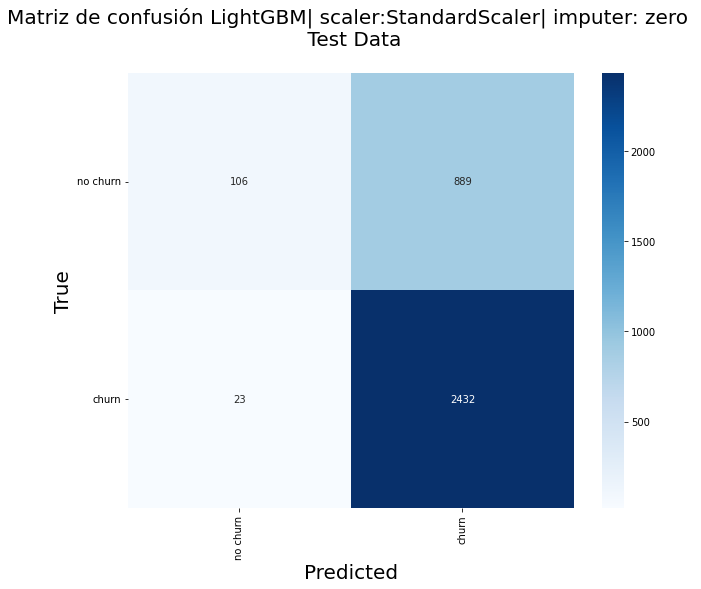

In [59]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión LightGBM| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Otros enfoques de entrenamiento

Debido a la gran variedad de modelos y de técnicas para intentar maximizar el desempeño de los mismos, es necesario explorarlas. Dependiendo del enfoque, tiempo disponible u otros factores, se pueden abordar más modelos o modificaciones de los modelos evaluados y comparar los resultados. A continuación intentamos evaluar el desempeño, usando otras técnicas de imputación de datos y enfoque para el escalado de variables numéricas. A su vez, analizamos el desempeño de los modelos al eliminar la reducción de dimensionalidad propuesta a través de Componentes Principales(PCA).


In [34]:
#Modelos con escalado minmax e imputación a través de la mediana
xgb_2=get_classifier_model("xgboost",scaler_method="minmax",imputer="median")
logistic_2=get_classifier_model("logistic_regression",scaler_method="minmax",imputer="median")
lightgbm_2=get_classifier_model("lightgbm",scaler_method="minmax",imputer="median")

In [35]:
xgb_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  19.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [36]:
logistic_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [37]:
lightgbm_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [117]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_median_minmax_pca']={'train':metrics(Y_train.ravel(),xgb_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_median_minmax_pca']={'train':metrics(Y_train.ravel(),logistic_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_median_minmax_pca']={'train':metrics(Y_train.ravel(),lightgbm_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7257 
 Precision: 0.7204 
 Recall: 0.9939 
 Specificity: 0.0993 
 Kappa: 0.1249 
 F1-Score: 0.8354 
ROC-AUC: 0.6464


	 Test 

 Accuracy:0.7354 
 Precision: 0.7314 
 Recall: 0.9927 
 Specificity: 0.1005 
 Kappa: 0.1263 
 F1-Score: 0.8422 
ROC-AUC: 0.6336


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.5890 
 Precision: 0.7553 
 Recall: 0.6108 
 Specificity: 0.5379 
 Kappa: 0.1319 
 F1-Score: 0.6754 
ROC-AUC: 0.6129


	 Test 

 Accuracy:0.6020 
 Precision: 0.7746 
 Recall: 0.6216 
 Specificity: 0.5538 
 Kappa: 0.1532 
 F1-Score: 0.6897 
ROC-AUC: 0.6225


===Métricas para LightGBM===


	 Training

 Accuracy:0.7264 
 Precision: 0.7215 
 Recall: 0.9923 
 Specificity: 0.1053 
 Kappa: 0.1303 
 F1-Score: 0.8355 
ROC-AUC: 0.6534


	 Test 

 Accuracy:0.7362 
 Precision: 0.7325 
 Recall: 0.9914 
 Specificity: 0.1065 
 Kappa: 0.1323 
 F1-Score: 0.8425 
ROC-AUC: 0.6332



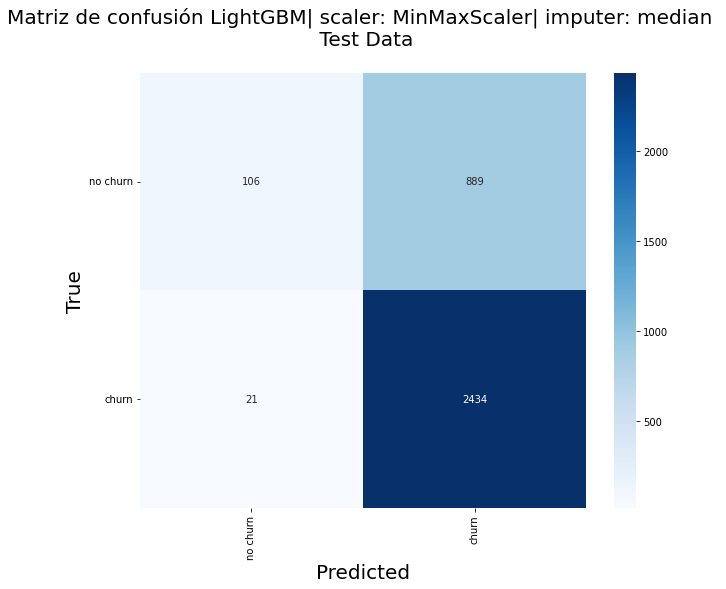

In [39]:
get_confusion_plot(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión LightGBM| scaler: MinMaxScaler| imputer: median \n Test Data\n")

### Analisis del Performance sin Componentes Principales

In [40]:
xgb_nopca=get_classifier_model("xgboost",pca=False)
logistic_nopca=get_classifier_model("logistic_regression",pca=False)
lightgbm_nopca=get_classifier_model("lightgbm",pca=False)

In [41]:
xgb_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1]},
             scoring='f1', verbose=True)

In [42]:
logistic_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.1min


c:\Users\jhonp\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'EgresosAnuales__c',
                                                                          'edad']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet']},
             scoring='f1', verbose=True)

In [43]:
lightgbm_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1]},
             scoring='f1', verbose=True)

In [118]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_nopca']={'train':metrics(Y_train.ravel(),xgb_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),xgb_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_nopca']={'train':metrics(Y_train.ravel(),logistic_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),logistic_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_nopca']={'train':metrics(Y_train.ravel(),lightgbm_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),lightgbm_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7256 
 Precision: 0.7185 
 Recall: 0.9998 
 Specificity: 0.0853 
 Kappa: 0.1152 
 F1-Score: 0.8361 
ROC-AUC: 0.6989


	 Test 

 Accuracy:0.7348 
 Precision: 0.7288 
 Recall: 0.9992 
 Specificity: 0.0824 
 Kappa: 0.1121 
 F1-Score: 0.8428 
ROC-AUC: 0.6399


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.5752 
 Precision: 0.7525 
 Recall: 0.5861 
 Specificity: 0.5499 
 Kappa: 0.1185 
 F1-Score: 0.6590 
ROC-AUC: 0.5996


	 Test 

 Accuracy:0.5788 
 Precision: 0.7682 
 Recall: 0.5845 
 Specificity: 0.5648 
 Kappa: 0.1271 
 F1-Score: 0.6639 
ROC-AUC: 0.6062


===Métricas para LightGBM===


	 Training

 Accuracy:0.7291 
 Precision: 0.7232 
 Recall: 0.9933 
 Specificity: 0.1122 
 Kappa: 0.1406 
 F1-Score: 0.8370 
ROC-AUC: 0.6631


	 Test 

 Accuracy:0.7365 
 Precision: 0.7324 
 Recall: 0.9923 
 Specificity: 0.1055 
 Kappa: 0.1322 
 F1-Score: 0.8428 
ROC-AUC: 0.6440



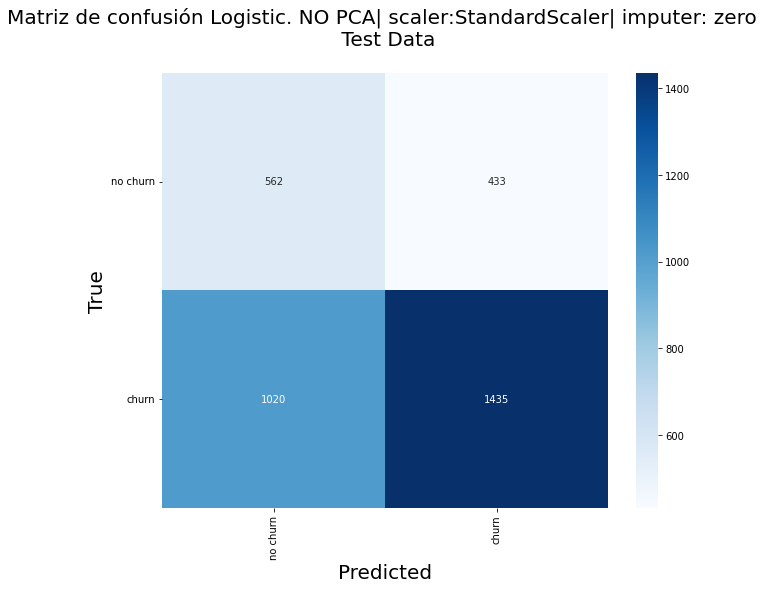

In [64]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),logistic_nopca.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión Logistic. NO PCA| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Stack de Modelos

Una alternativa muy común al tener varios modelos, es el realizar stack de uno o más modelos y realizar una operación que puede partir de promediar hasta generar un nuevo modelo su resultado para obtener una mejor estimación. A continuación se intenta con LightGBM y la Regresión Logística

In [124]:
def pred_stack(data,proba=True,thresh=0.5):
    proba_lgb=lightgbm.predict_proba(data)[:,1]
    predict_log=logistic.predict_proba(data)[:,1]
    if proba:
        return np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)
    else:
        return (np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)>thresh).astype(int)

In [125]:
## Métricas para stacking

print("\n===Métricas para Stacking LightGBM y Logistic ===\n")
print("\n\t Training\n")
results['stack_lightgbm_logistic']={'train':metrics(Y_train.ravel(),pred_stack(X_train,False))}
roc=roc_auc_score(Y_train.ravel(),pred_stack(X_train))
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['stack_lightgbm_logistic']['test']=metrics(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"]),False))
roc=roc_auc_score(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"])))
print("ROC-AUC: {:.4f}\n".format(roc))


===Métricas para Stacking LightGBM y Logistic ===


	 Training

 Accuracy:0.7146 
 Precision: 0.7238 
 Recall: 0.9581 
 Specificity: 0.1460 
 Kappa: 0.1328 
 F1-Score: 0.8246 
ROC-AUC: 0.6537


	 Test 

 Accuracy:0.7180 
 Precision: 0.7330 
 Recall: 0.9495 
 Specificity: 0.1467 
 Kappa: 0.1228 
 F1-Score: 0.8273 
ROC-AUC: 0.6324



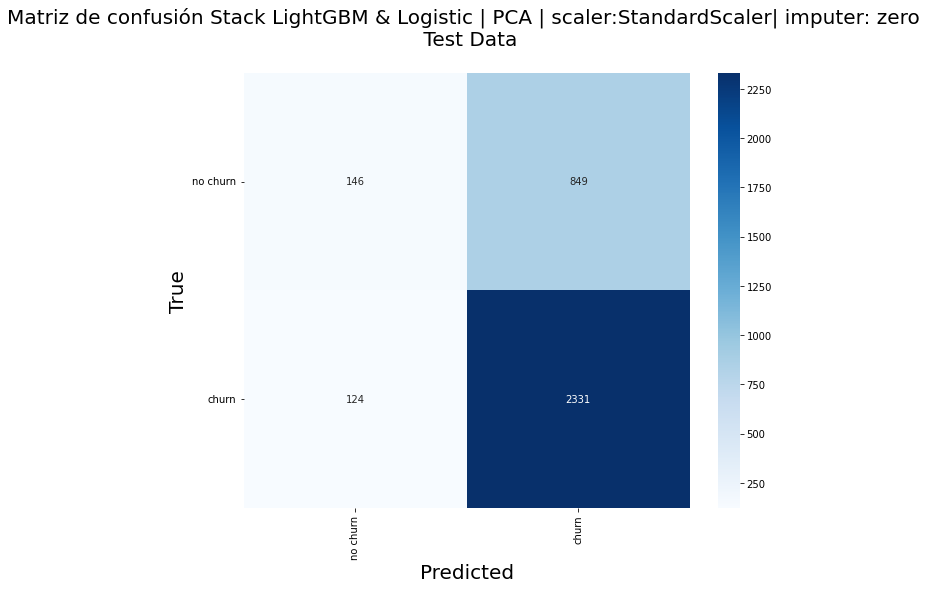

In [126]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"]),False),class_names=['no churn','churn'],title="Matriz de confusión Stack LightGBM & Logistic | PCA | scaler:StandardScaler| imputer: zero \n Test Data\n")

## Resumir métricas de desempeño

In [120]:
results_df=pd.DataFrame([(k,k1,v1['kappa'],v1['accuracy'],v1['prec'],v1['f1'],v1['recall'],v1['specificity']) for k,v in results.items() for k1,v1 in v.items()],columns=['model','etapa','kappa','accuracy','precision','f1','recall','specificity'])
results_df=results_df.melt(id_vars=['model','etapa'],value_vars=['kappa','accuracy','precision','f1','recall','specificity'],value_name="valor",var_name="Métrica")

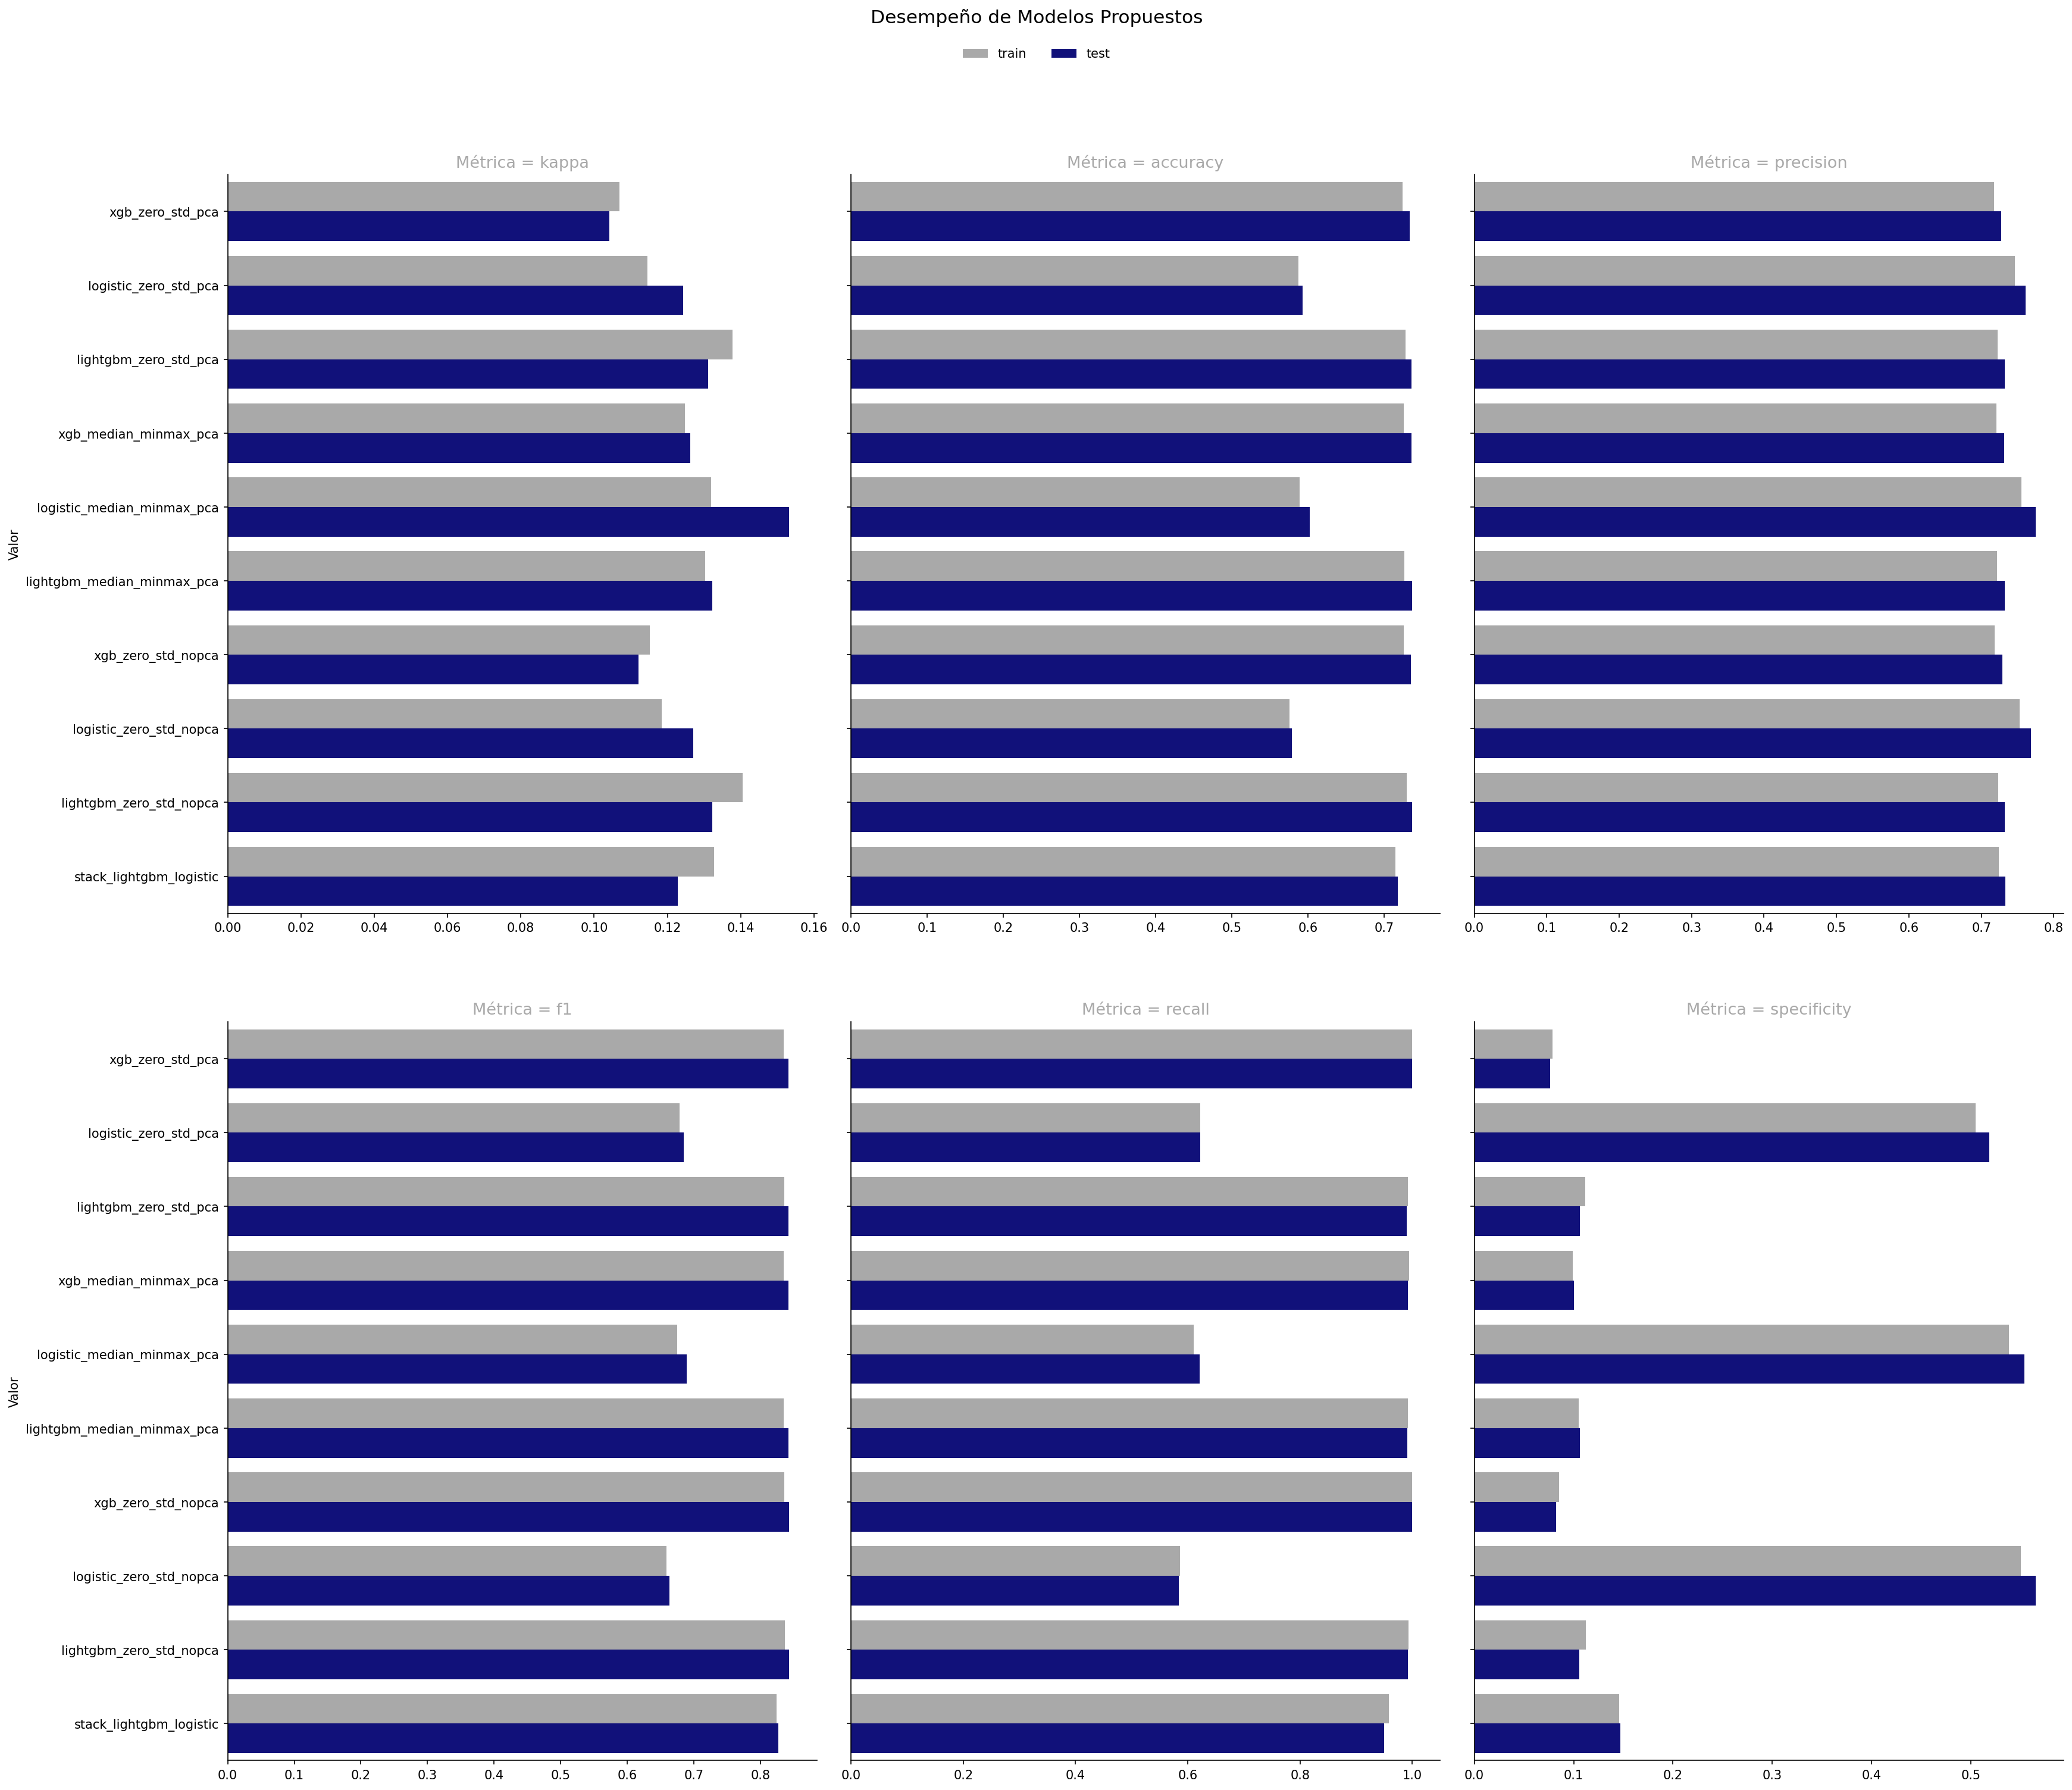

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.catplot(y="model", x="valor", col="Métrica",hue="etapa",kind="bar",legend=True,
                data=results_df,col_wrap=3,sharex=False,aspect=1.5,orient="h",palette={'train':'darkgray','test':'darkblue'})
for i in g.axes:
    i.set_ylabel("Valor")
    i.set_title(i.get_title(),size=13)
    i.title.set_color("darkgray")
    #i.set_xticklabels(i.get_xticklabels(), rotation=90)
    i.set_xlabel("\n")
g.figure.suptitle("Desempeño de Modelos Propuestos", y=1.02,size=15);
g.fig.tight_layout()
g.fig.set_figheight(20)
g.fig.set_dpi(150)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.985),
    ncol=2,
    title=None, frameon=False
)


## Discusión

- La selección del mejor modelo dependerá de las necesidades de negocio. Sin embargo, en cuanto a especificidad, la regresión logística sin reducción de dimensionalidad(PCA), imputación de ceros en variables numéricas y standardScaler obtuvo el mejor desempeño. Por otro, lado fue la de peor recall y score F1. 

- El modelo más robusto de los propuestos, si se desea detectar el churn principalmente, en términos de precisión, score f1 y kappa fue el stacking de modelos LightGBM y Regresión Logística (con reducción de dimensionalidad(PCA), imputación de ceros y standardScaler). Sin embargo, cabe la posibilidad de explorar modelos adicionales o mas hiperparámetros de los modelos propuestos.

- Existen otras posibilidades de exploración en cuanto a encontrar el mejor modelo, y es hacer un análisis con diferentes puntos de corte para la probabilidad. Actualmente para los modelos logísticos, se asume el churn si la probabilidad que arroja el modelo es mayor a 0.5. Sin embargo, este valor puede modificarse para evaluar el comportamiento de las métricas con puntos de corte diferentes.


### Exportar modelos para futuro uso

In [127]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

with open("models/xgbmodel.pickle","wb") as f:
    pickle.dump(xgb,f)

with open("models/logistic.pickle","wb") as f:
    pickle.dump(logistic,f)

with open("models/lightgbm.pickle","wb") as f:
    pickle.dump(lightgbm,f)

with open("models/xgbmodel2.pickle","wb") as f:
    pickle.dump(xgb_2,f)

with open("models/logistic2.pickle","wb") as f:
    pickle.dump(logistic_2,f)

with open("models/lightgbm2.pickle","wb") as f:
    pickle.dump(lightgbm_2,f)

with open("models/xgbmodel_nopca.pickle","wb") as f:
    pickle.dump(xgb_nopca,f)

with open("models/logistic_nopca.pickle","wb") as f:
    pickle.dump(logistic_nopca,f)

with open("models/lightgbm_nopca.pickle","wb") as f:
    pickle.dump(lightgbm_nopca,f)


In [4]:
##reutilizar | leer modelos guardados
import pickle
with open("models/logistic_2.pickle", 'rb') as f:
    logistic_2 = pickle.load(f)